In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

if tf.config.list_physical_devices('GPU'):
    print('GPU available!')
else:
    print('No GPU available')
print(tf.config.list_physical_devices('GPU'))

No GPU available
[]


In [10]:
path_to_image_set = 'Covid19-dataset'

In [11]:
# Printing folder / class names.
folder_names = os.listdir(path_to_image_set)
print(folder_names)

['Covid', 'Normal', 'Viral Pneumonia']


In [12]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 64
SEED = 0

datagen_train = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_image_set,
    validation_split=0.2,
    labels='inferred',
    subset='training',
    image_size=[IMG_HEIGHT, IMG_WIDTH],
    batch_size=BATCH_SIZE,
    seed=SEED  
)

datagen_valid = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_image_set,
    validation_split=0.2,
    labels='inferred',
    subset='validation',
    image_size=[IMG_HEIGHT, IMG_WIDTH],
    batch_size=BATCH_SIZE,
    seed=SEED  
)

class_names = datagen_train.class_names

ds_train = datagen_train.prefetch(buffer_size=tf.data.AUTOTUNE)
ds_valid = datagen_valid.prefetch(buffer_size=tf.data.AUTOTUNE)

num_classes = len(class_names)
print(f'\nThe {num_classes} class names are listed below.')
print(class_names)

Found 312 files belonging to 3 classes.
Using 250 files for training.
Found 312 files belonging to 3 classes.
Using 62 files for validation.

The 3 class names are listed below.
['Covid', 'Normal', 'Viral Pneumonia']


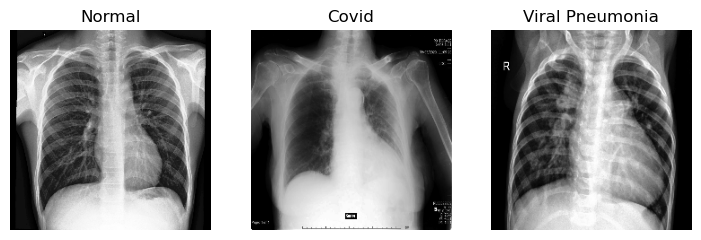

In [13]:

plt.figure(figsize=(15,15))

# From the first batch of images from the training dataset...
for images, labels in ds_train.take(1):
    
    # ...plot an example image for each unique class.
    visited = set()
    i = 0
    while len(visited) < num_classes:
        
        # Get the image and its label
        image = images[i].numpy().astype("uint8")
        label = class_names[labels[i]]
        
        # If we didn't already show an example image of the label...
        if label not in visited:
            
            # ...record the label
            visited.add(label)

            # Plot the image and its label
            ax = plt.subplot(1, 5, len(visited))
            plt.imshow(image)
            plt.title(label)
            plt.axis("off")
        
        i+=1


In [ ]:
from tensorflow.keras import regularizers
keras.backend.clear_session()

model = keras.Sequential(
    [
        keras.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3]),
        
        layers.RandomFlip(mode='horizontal'),
        layers.RandomFlip(mode='vertical'),
        layers.RandomRotation(factor=0.20),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        
        layers.BatchNormalization(renorm=True),
        layers.Conv2D(64, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(),
        
        layers.BatchNormalization(renorm=True),
        layers.Conv2D(128, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(),
        
        layers.BatchNormalization(renorm=True),
        layers.Conv2D(256, kernel_size=3, activation="relu"),
        layers.Conv2D(256, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(),
        
        layers.BatchNormalization(renorm=True),
        layers.Flatten(),
        layers.Dense(128, activation = "relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation = "relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"), 
    ]
)

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50

keras.backend.clear_session()


#pretrained_base = VGG16(weights="imagenet", include_top=False)
pretrained_base = ResNet50(weights='imagenet', include_top=False)

pretrained_base.trainable = False

model = keras.Sequential(
    [
        keras.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3]),
        
        layers.RandomFlip(mode='horizontal'),
        layers.RandomFlip(mode='vertical'),
        layers.RandomZoom(0.20),
        layers.RandomHeight(0.20),
        layers.RandomWidth(0.20),
        layers.RandomRotation(factor=0.20),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        
        pretrained_base,
        
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(), # Helps with overfitting by reducing the number of parameters.
        #layers.Dense(1024, activation = "relu"),
        #layers.Dense(2048, activation = "relu"),
        #layers.Dense(1024, activation = "relu"),
        #layers.Dense(512, activation = "relu"),
        #layers.Dense(256, activation = "relu"),
        
        #layers.Dense(256, activation='relu'),
        #layers.Dropout(0.2),
        #layers.Dense(512, activation='relu'),
        #layers.Dropout(0.2),
        #layers.Dense(256, activation='relu'),
        #layers.Dropout(0.2),
        
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation="softmax"), 
    ]
)

94765736/94765736 [==============================] - 2s 0us/step


In [15]:
model.compile(
    #optimizer=tf.keras.optimizers.Adam(epsilon=0.001),
    optimizer='sgd',
    #optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    # If targets (class-labels) are one-hot encoded, use categorical_crossentropy. Otherwise, if they are a
    # list of integers, use sparse_categorical_crossentropy.
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [17]:
EPOCHS = 400

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/400
4/4 [==============================] - 12s 3s/step - loss: 1.2448 - accuracy: 0.3120 - val_loss: 1.2847 - val_accuracy: 0.4032
Epoch 2/400
4/4 [==============================] - 12s 3s/step - loss: 1.1268 - accuracy: 0.4160 - val_loss: 1.2231 - val_accuracy: 0.4194
Epoch 3/400
4/4 [==============================] - 12s 3s/step - loss: 1.1048 - accuracy: 0.4520 - val_loss: 1.1775 - val_accuracy: 0.4194
Epoch 4/400
4/4 [==============================] - 11s 3s/step - loss: 1.0953 - accuracy: 0.4200 - val_loss: 1.1423 - val_accuracy: 0.4194
Epoch 5/400
4/4 [==============================] - 10s 3s/step - loss: 1.1035 - accuracy: 0.4040 - val_loss: 1.1087 - val_accuracy: 0.4194
Epoch 6/400
4/4 [==============================] - 10s 2s/step - loss: 1.0752 - accuracy: 0.4480 - val_loss: 1.0841 - val_accuracy: 0.4516
Epoch 7/400
4/4 [==============================] - 10s 2s/step - loss: 1.0488 - accuracy: 0.4480 - val_loss: 1.0659 - val_accuracy: 0.4516
Epoch 8/400
4/4 [==========

Text(0.5, 1.0, 'Loss')

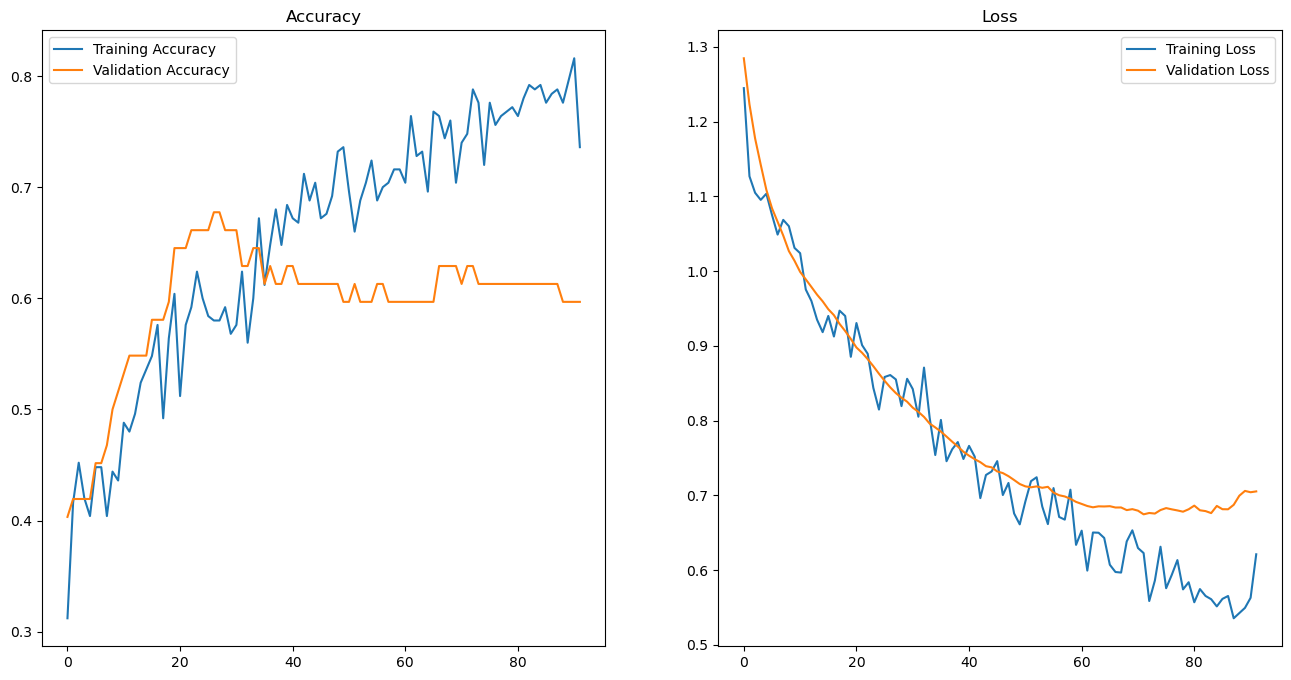

In [18]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

In [19]:
val_loss, val_accuracy = model.evaluate(ds_valid)
print(f'Validation Accuracy: {val_accuracy}')
print('Best Validation Accuracy: ', max(history.history['val_accuracy']))

1/1 [==============================] - 2s 2s/step - loss: 0.6745 - accuracy: 0.6290
Validation Accuracy: 0.6290322542190552
Best Validation Accuracy:  0.6774193644523621
